In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_venn import venn2
from src.tests.team_2.model_trainer_2 import load_data
from src.tests.team_2.model_trainer_2 import retrain
from src.utils.feature_analyzer import *
from src.utils.plot_utils import *
from src.utils.test_utils import *
from src.tests.team_2.model_trainer_2 import data_manipulator


C:\Users\alexz\AppData\Local\Temp\ipykernel_37912\3552481454.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
###PIPELINE###
# 1 load training data
# 2 evaluate feature importance with permutation feature
# 3 select top feature to create a test for bias
# 5 test if there is actually bias
# 6 choose that feature or not.
# 7 remove feature from training data
# 8 repeat (2-7) until we have 5 features we believe have the most bias



In [4]:
biased_features = []

In [5]:
###TRAIN: no features removed
# X, y = load_data('../../data/synth_data_train_labeled.csv')
# retrain(X, y)

In [6]:
###LOAD DATA
RANDOM_STATE = 42

# Load in data (go back two parent directories)
df = pd.read_csv('data/investigation_train_large_checked.csv')
# Load in data descriptions
data_desc = pd.read_csv('data/data_description.csv', encoding='ISO-8859-1')

# Replace dutch for english names
name_mapping = dict(zip(data_desc['Feature (nl)'], data_desc['Feature (en)']))
# Rename the columns in the `data` DataFrame
df.rename(columns=name_mapping, inplace=True)

# Show data head
df.head()


,address_number_personal_records_database_addresses,address_number_different_districts,address_number_mail_address,address_number_residential_address_manual,address_days_at_address,address_latest_part_rotterdam,address_latest_neighborhood_groot_ijsselmonde,address_latest_neighborhood_new_westen,address_latest_neighborhood_other,address_latest_neighborhood_olde_north,...,type_hist_ind,type_hist_care_sector,type_ind,type_indication_secret_data,type_other,type_transport_logistics_horticulture,type_care_cleaning_wellbeing,Ja,Nee,checked
0,1,1,0,0,23240,1,0,0,0,0,...,1,0,0,0,0,0,0,0.617698,0.382302,False
1,4,2,1,1,1971,1,0,0,1,0,...,1,0,1,0,1,0,0,0.602167,0.397833,False
2,6,4,2,1,7247,0,0,0,1,0,...,1,0,1,0,0,0,0,0.512377,0.487623,False
3,3,2,0,1,8060,1,0,0,1,0,...,1,0,0,0,0,0,0,0.717796,0.282204,True
4,3,2,0,0,18705,1,0,0,0,0,...,1,0,1,0,0,0,0,0.705484,0.294516,True


In [7]:
def analyze_features(data, cache, filename):
    fa = FeatureAnalyzer()
    if cache:
        fa.evaluate_importance(dataframe=data, target='checked', add_drop=['Ja', 'Nee'], filepath=filename)
    fa = FeatureAnalyzer()
    fa.load_importance(filepath=filename)

    # Select original training data
    X = df.drop(['checked', 'Ja', 'Nee'], axis=1)
    y = df['checked']
    # Convert permutation importance to dictionary
    perm_import = fa.feature_importance_as_dict(column_names=X.columns, normalize=True)
    # Convert to pd series and sort from high to low
    perm_import = pd.Series(perm_import)
    # sort from high to low
    sorted_perm = perm_import.sort_values(ascending=False)

    top_5 = sorted_perm.head(10)
    top_5_sorted = top_5.sort_values(ascending=True)

    # Set the figure size for better readability
    plt.figure(figsize=(10,4))

    # Create a horizontal bar chart
    top_5_sorted.plot(kind='barh', color='skyblue')

    # Add titles and labels
    plt.title('Top 10 Feature based on Permutation Importances', fontsize=16)
    plt.xlabel('Importance Score', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    # Display sorted value
    for i, (value, feature) in enumerate(zip(top_5_sorted.values, top_5_sorted.index)):
        plt.text(value, i, f' {value:.2f}', va='center')
    # Enhance layout for better spacing
    plt.tight_layout()
    # Display the plot
    plt.show()


In [8]:
def plot_values(feature, data):
    counts = data[feature].value_counts().sort_index()

    plt.figure(figsize=(8,2))
    counts.plot(kind='bar', color='skyblue')
    plt.title(f'Frequency of {feature}', fontsize=14)
    plt.xlabel(f'{feature}', fontsize=14)
    plt.ylabel('Counts', fontsize=14)

In [9]:
def process_bias(data_path, model_path, feature, new_value, is_range, detailed_results, name_original=None, name_changed=None):
    if is_range:
        acc_original, acc_changed, p_value, dataset_size, original_checked_cnt, changed_checked_cnt = test_bias_with_range(
            data_path, model_path, feature, new_value)
    else:
        acc_original, acc_changed, p_value, dataset_size, original_checked_cnt, changed_checked_cnt = test_bias(
            data_path, model_path, feature, new_value)

    if detailed_results:
        show_stats(dataset_size, acc_original, name_original, acc_changed, name_changed, original_checked_cnt, changed_checked_cnt)

    if p_value < 0.05:
        print(p_value)
        print(f'Model showcases significant bias towards feature - {feature}')
    elif p_value > 0.05:
        print(p_value)
        print(f'Model does not showcase significant bias towards feature - {feature}')

def show_stats(dataset_size, acc_original, f_name_original, acc_changed, f_name_changed, original_checked_cnt, changed_checked_cnt):
    print(f'Accuracy for sample of {dataset_size} {f_name_original}: {acc_original * 100:.1f}%')
    print(f'Accuracy for sample of {dataset_size} {f_name_changed}: {acc_changed * 100:.1f}%')
    print(f'Percentage checked amongst {f_name_original}: {original_checked_cnt * 100 / dataset_size:.1f}%')
    print(f'Percentage checked changed to {f_name_changed}: {changed_checked_cnt * 100 / dataset_size:.1f}%')

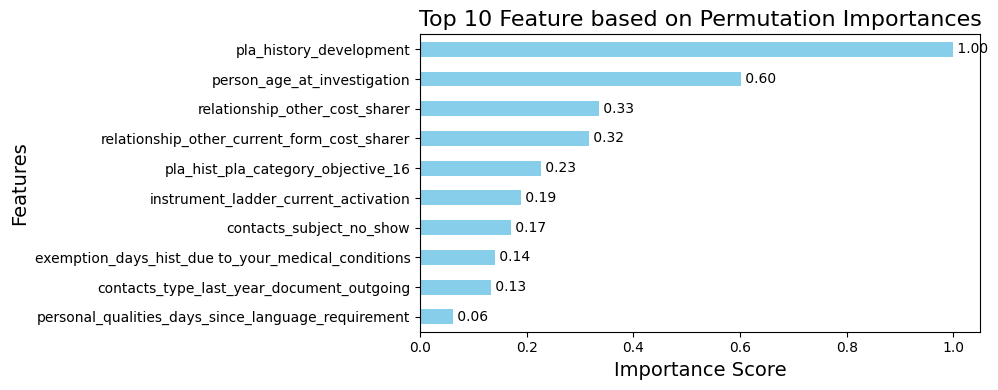

In [10]:
#ANALYZE: no features removed
analyze_features(df, False, 'src/team_2/feature_importance/fi_v0.pkl')

{'18-23': 22400, '23-28': 20600, '28-33': 17500, '33-38': 12900, '38-42': 10800, '42-47': 3000, '52-57': 800, '57-62': 4600, '62-67': 11700}


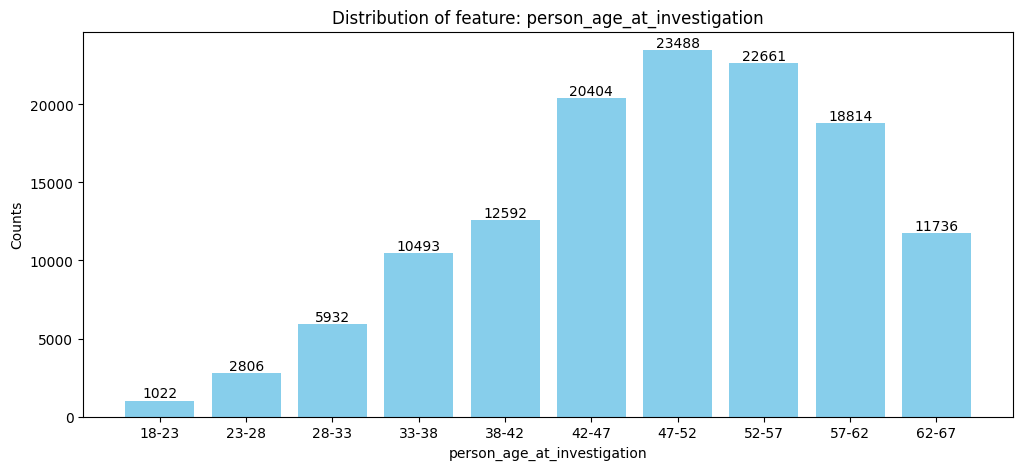

In [11]:
plot_distribution(df['person_age_at_investigation'], 'person_age_at_investigation')

In [12]:
###TEST: bias on age
only = pd.read_csv('data/Experiment_persoon_leeftijd_bij_onderzoek/20_only.csv')
only.head(10)



process_bias(
    data_path='data/Experiment_persoon_leeftijd_bij_onderzoek/20_only.csv',
    model_path='model/gboost1_v1.onnx',
    feature=['persoon_leeftijd_bij_onderzoek'],
    new_value=[50],
    is_range=False,
    detailed_results=True,
    name_original='20 year old',
    name_changed='50 year old'
)


Accuracy for sample of 500 20 year old: 88.8%
Accuracy for sample of 500 50 year old: 82.0%
Percentage checked amongst 20 year old: 49.4%
Percentage checked changed to 50 year old: 31.8%
1.1579228413454308e-08
Model showcases significant bias towards feature - ['persoon_leeftijd_bij_onderzoek']


In [13]:
###FEATURE SELECTION
biased_features.append('persoon_leeftijd_bij_onderzoek')

In [14]:
df = df.drop(name_mapping['persoon_leeftijd_bij_onderzoek'], axis=1)

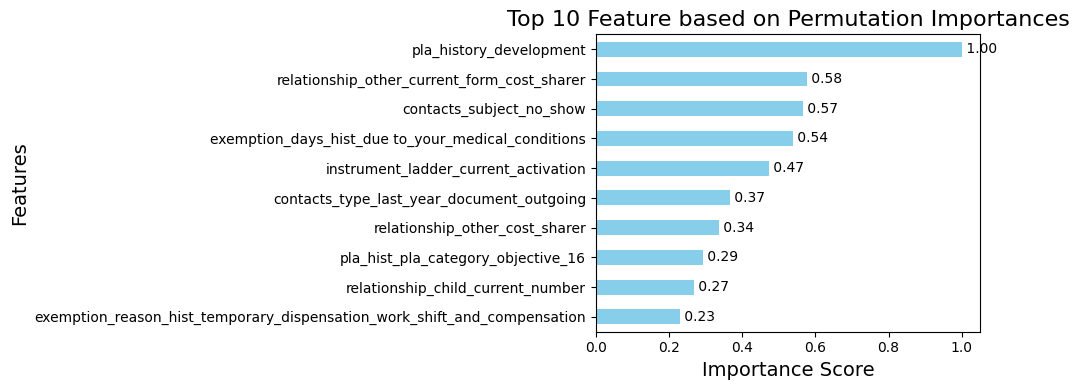

In [15]:
### Get feature importance for dataframe without persoon_leeftijd_bij_onderzoek

###REPEAT STEPS
analyze_features(df, False, 'src/team_2/feature_importance/fi_v1.pkl')

{0: 31000}


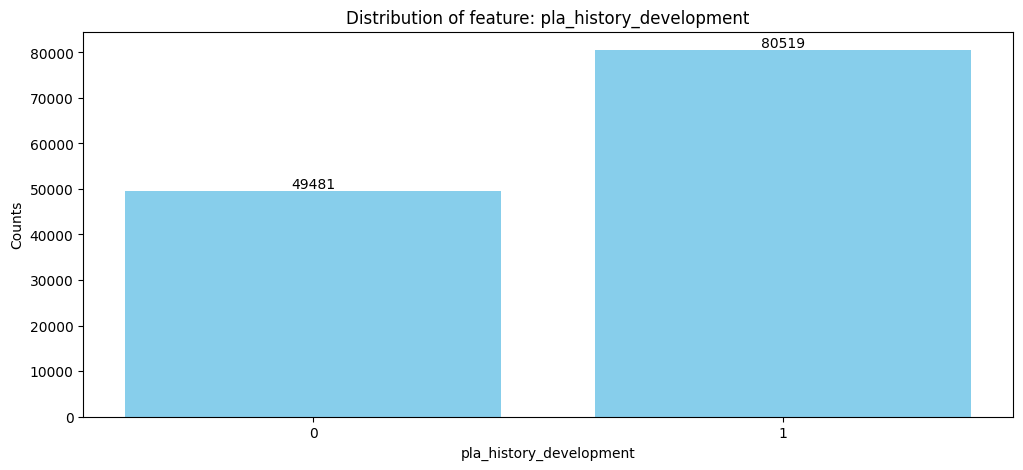

In [16]:
plot_distribution(df['pla_history_development'], 'pla_history_development')

In [17]:
###TEST: bias on history of plans
process_bias(
    data_path='data/Experiment_pla_historie_ontwikkeling/0_only.csv',
    model_path='model/gboost1_v1.onnx',
    feature=['pla_historie_ontwikkeling'],
    new_value=[1],
    is_range=False,
    detailed_results=True,
    name_original='Had no action plan (0)',
    name_changed='Had action plan (1)'
)

Accuracy for sample of 500 Had no action plan (0): 94.4%
Accuracy for sample of 500 Had action plan (1): 85.4%
Percentage checked amongst Had no action plan (0): 41.8%
Percentage checked changed to Had action plan (1): 28.8%
1.5907344288089193e-05
Model showcases significant bias towards feature - ['pla_historie_ontwikkeling']


In [18]:
###FEATURE SELECTION
biased_features.append('pla_historie_ontwikkeling')

In [19]:
df = df.drop(name_mapping['pla_historie_ontwikkeling'], axis=1)

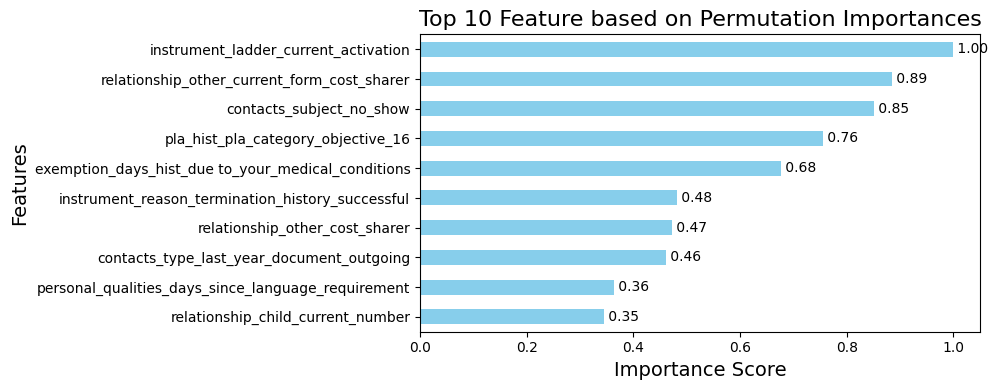

In [20]:
###REPEAT
analyze_features(df, False, 'src/team_2/feature_importance/fi_v2.pkl')

{1: 1000, 2: 54700, 3: 61700}


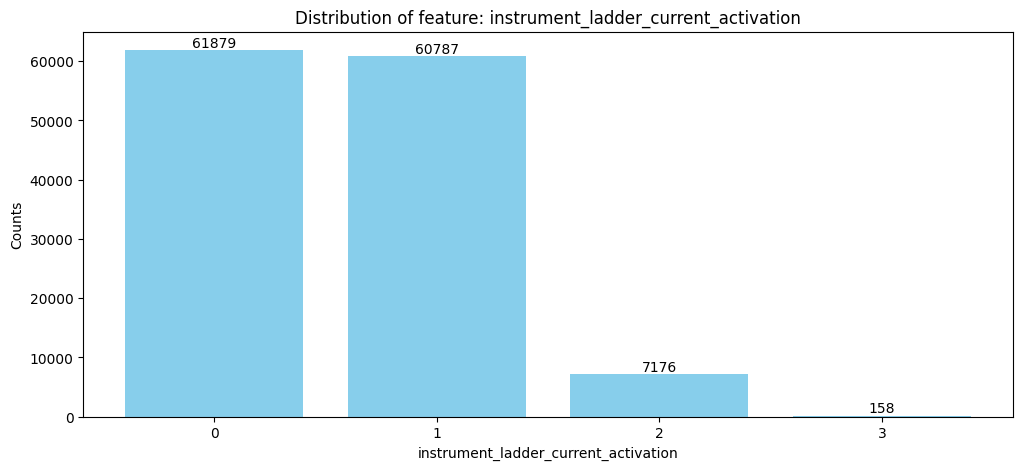

In [21]:
plot_distribution(df['instrument_ladder_current_activation'], 'instrument_ladder_current_activation')

In [22]:
###TEST
process_bias(
    data_path='data/Experiment_instrument_ladder_huidig_activering/01_curr_inst_2-3_labeled.csv',
    model_path='model/gboost1_v1.onnx',
    feature='instrument_ladder_huidig_activering',
    new_value=(0,1),
    is_range=True,
    detailed_results=True,
    name_original='Curr number of instruments: 2-3',
    name_changed='Curr number of instruments: 0-1'
)

Accuracy for sample of 500 Curr number of instruments: 2-3: 98.4%
Accuracy for sample of 500 Curr number of instruments: 0-1: 97.0%
Percentage checked amongst Curr number of instruments: 2-3: 1.6%
Percentage checked changed to Curr number of instruments: 0-1: 3.4%
0.06842975906613978
Model does not showcase significant bias towards feature - instrument_ladder_huidig_activering


In [23]:
biased_features.append('instrument_ladder_huidig_activering')
biased_features

['persoon_leeftijd_bij_onderzoek',
 'pla_historie_ontwikkeling',
 'instrument_ladder_huidig_activering']

In [24]:
df = df.drop(name_mapping['instrument_ladder_huidig_activering'], axis=1)

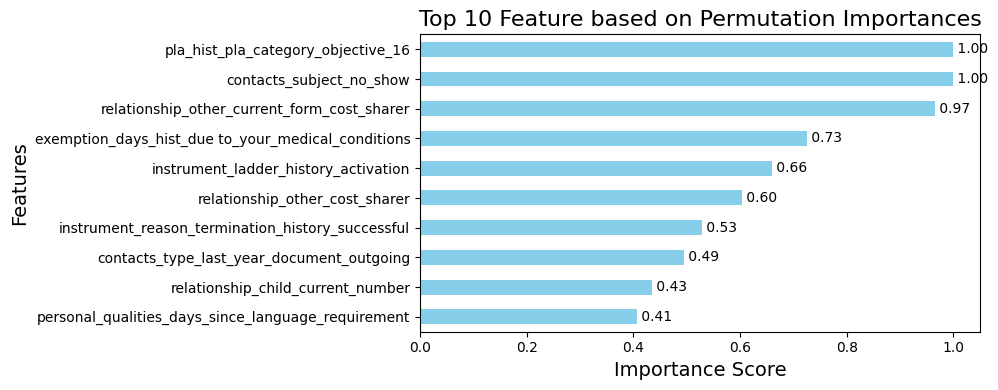

In [25]:
###REPEAT
analyze_features(df, False, 'src/team_2/feature_importance/fi_v3.pkl')

{0: 23900, 2: 30200, 3: 50500, 4: 57000, 5: 58200, 6: 58300}


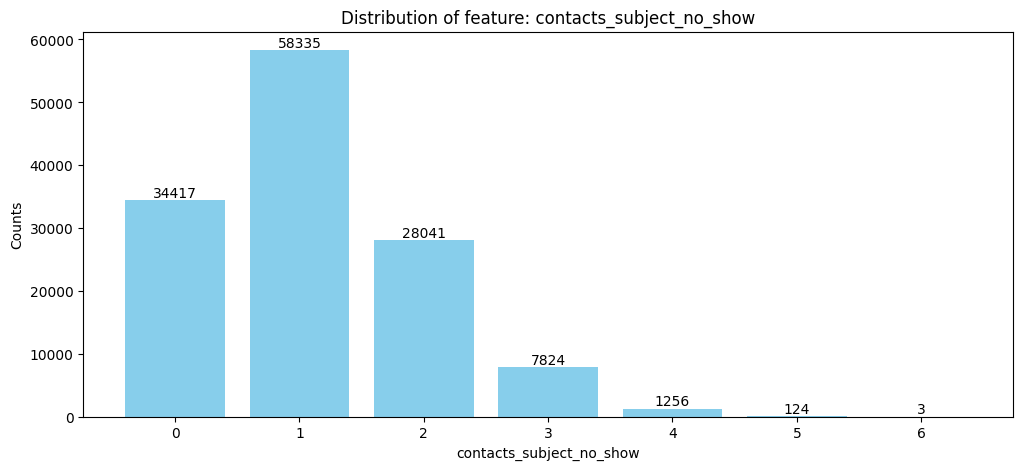

In [26]:
plot_distribution(df['contacts_subject_no_show'], 'contacts_subject_no_show')

In [27]:
process_bias(
    data_path='data/Experiment_contacten_onderwerp_no_show/02_contact_3-6_labeled.csv',
    model_path='model/gboost1_v1.onnx',
    feature='contacten_onderwerp_no_show',
    new_value=(0,2),
    is_range=True,
    detailed_results=True,
    name_original='No show count: 3-6',
    name_changed='No show count: 0-2'
)

Accuracy for sample of 1500 No show count: 3-6: 90.7%
Accuracy for sample of 1500 No show count: 0-2: 84.2%
Percentage checked amongst No show count: 3-6: 26.9%
Percentage checked changed to No show count: 0-2: 15.0%
9.929528174431414e-16
Model showcases significant bias towards feature - contacten_onderwerp_no_show


In [28]:
biased_features.append('contacten_onderwerp_no_show')

In [29]:
df = df.drop(name_mapping['contacten_onderwerp_no_show'], axis=1)

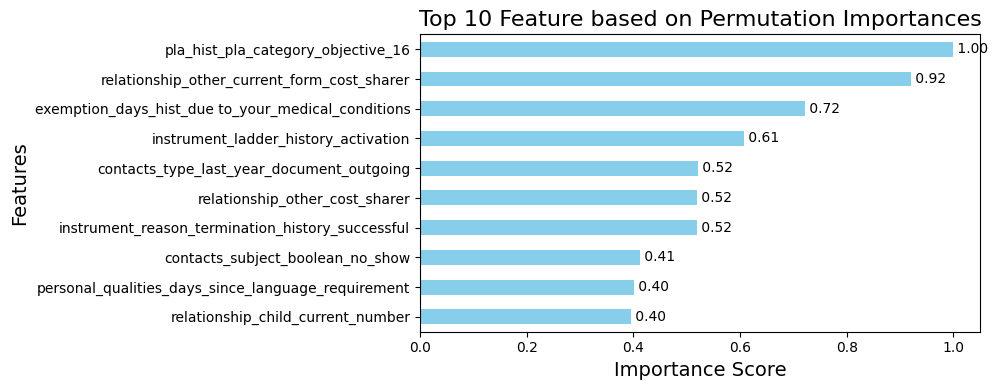

In [30]:
analyze_features(df, False, 'src/team_2/feature_importance/fi_v4.pkl')

{0: 5700, 2: 57500, 3: 64200}


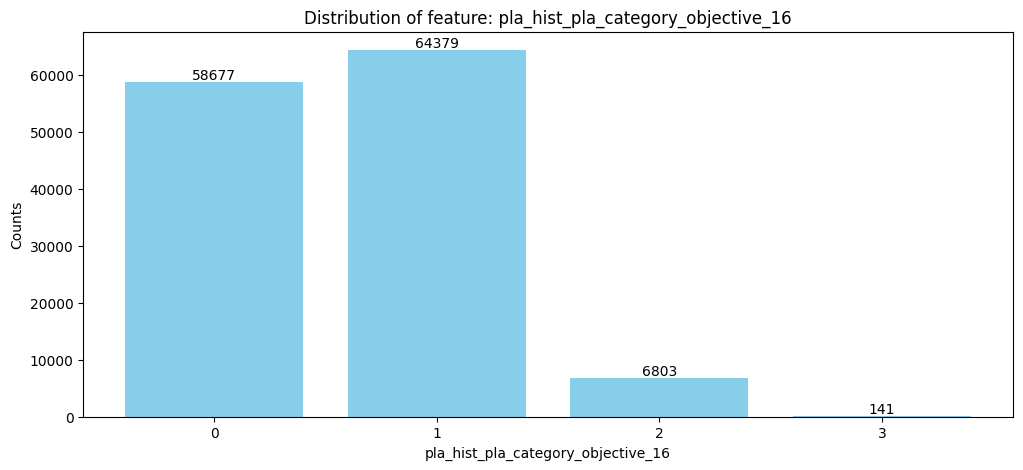

In [31]:
plot_distribution(df['pla_hist_pla_category_objective_16'], 'pla_hist_pla_category_objective_16')

In [32]:
process_bias(
    data_path='data/Experiment_pla_hist_pla_categorie_doelstelling_16/03_obj_16_2-3_labeled.csv',
    model_path='model/gboost1_v1.onnx',
    feature='pla_hist_pla_categorie_doelstelling_16',
    new_value=(0,1),
    is_range=True,
    detailed_results=True,
    name_original='Obj 16 count: 2-3',
    name_changed='Obj 16 count: 0-1'
)

Accuracy for sample of 1000 Obj 16 count: 2-3: 99.3%
Accuracy for sample of 1000 Obj 16 count: 0-1: 99.3%
Percentage checked amongst Obj 16 count: 2-3: 2.0%
Percentage checked changed to Obj 16 count: 0-1: 2.2%
0.7552625892147711
Model does not showcase significant bias towards feature - pla_hist_pla_categorie_doelstelling_16


In [33]:
biased_features.append('')
biased_features

['persoon_leeftijd_bij_onderzoek',
 'pla_historie_ontwikkeling',
 'instrument_ladder_huidig_activering',
 'contacten_onderwerp_no_show',
 '']

In [34]:
# Check if there is a bias towards females
process_bias(
    data_path='data/Experiment_persoon_geslacht_vrouw/male_only.csv',
    model_path='model/gboost1_v1.onnx',
    feature=[['persoon_geslacht_vrouw']],
    new_value=[1],
    is_range=False,
    detailed_results=True,
    name_original='Male is true',
    name_changed='Female is true'
)

Accuracy for sample of 1000 Male is true: 94.7%
Accuracy for sample of 1000 Female is true: 94.7%
Percentage checked amongst Male is true: 8.2%
Percentage checked changed to Female is true: 8.2%
1.0
Model does not showcase significant bias towards feature - [['persoon_geslacht_vrouw']]


### Data Manipulation

In [50]:
# load in original df again
df = pd.read_csv('data/investigation_train_large_checked.csv')

{1: 3900}


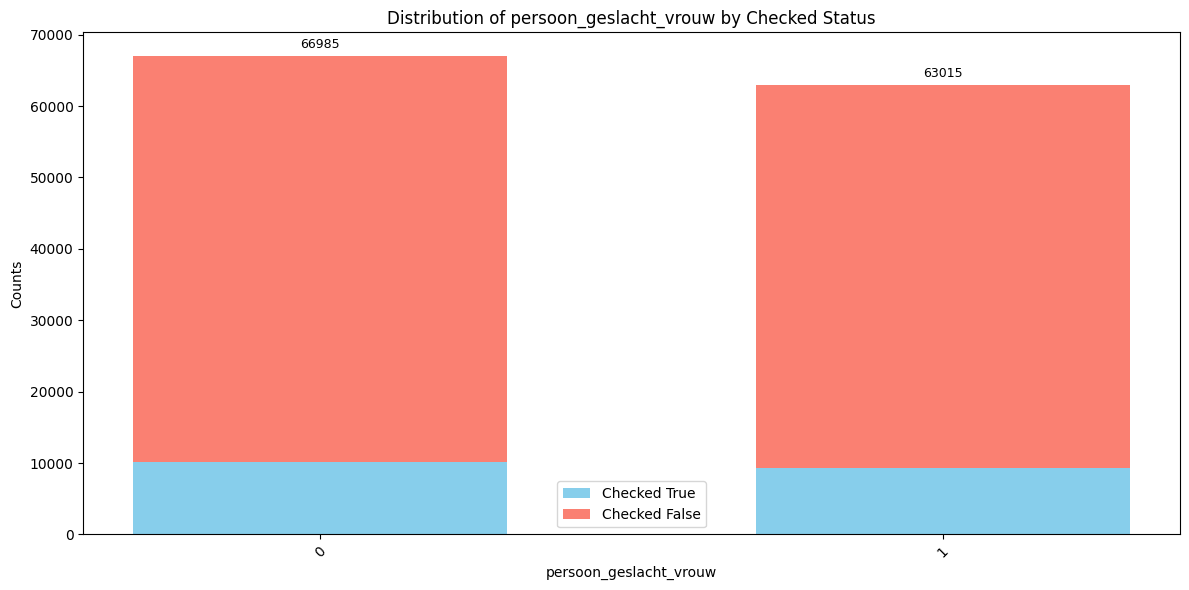

In [51]:
### WE WANT TO INTRODUCE A BIAS TOWARDS WOMAN
# Check distribution on women in data
plot_dist_checked(df=df, feature='persoon_geslacht_vrouw')

{1: 52300}


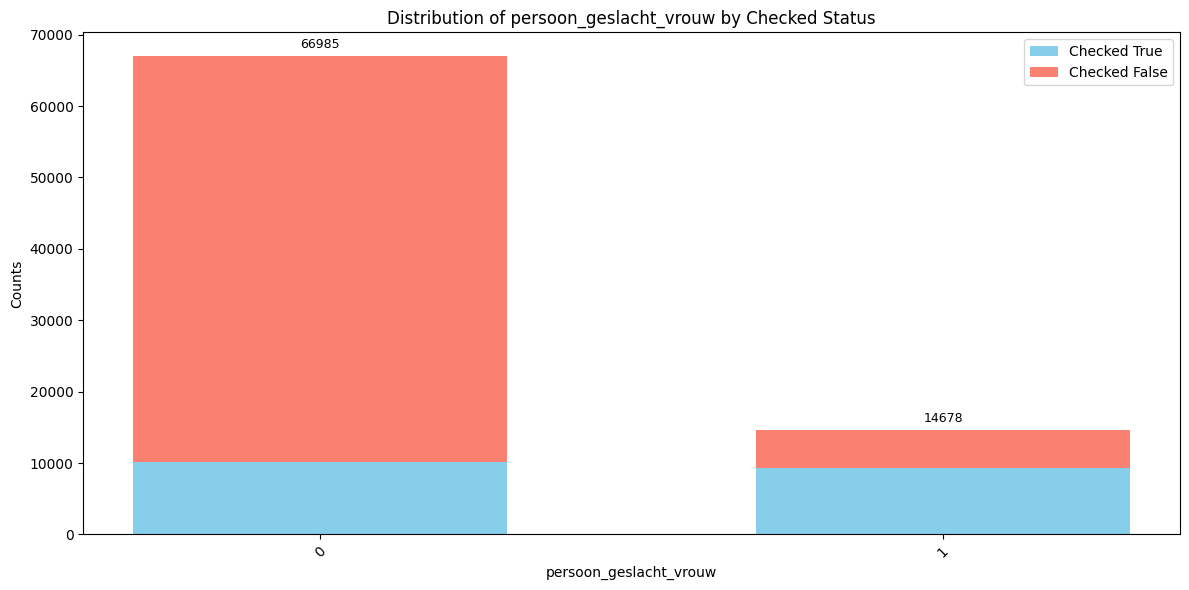

In [ ]:
# No siginificant bias was shown towards women, let's try to introduce this by data manipulation.
manipulated_data = data_manipulator(
    data=df,
    feature=['persoon_geslacht_vrouw'],
    manipulation='remove',
    fraction=0.9,
    remove_condition=lambda row: row['persoon_geslacht_vrouw'] == 1 and row['checked'] == False
)

### We removed 90% of the labels where the women has a checked label that is false from training data

plot_dist_checked(df=manipulated_data, feature='persoon_geslacht_vrouw')

In [ ]:
# No siginificant bias was shown towards women, let's try to introduce this by data manipulation.
manipulated_data = data_manipulator(
    data=df,
    feature=['persoon_geslacht_vrouw'],
    manipulation='remove',
    fraction=0.95,
    remove_condition=lambda row: row['persoon_geslacht_vrouw'] == 1 and row['checked'] == False
)

### We replace labels where the women has a checked label that is false from training data

plot_dist_checked(df=manipulated_data, feature='persoon_geslacht_vrouw')